In [1]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import string
from datetime import datetime
from utils.database_util import DatabaseUtil
from IPython.display import Image
pd.options.display.float_format = '{:,.0f}'.format

# Data Cleaning and Preparation

In [2]:
# connect to the sqlite3 db file, utilizing the customized module : utils
DBUtil = DatabaseUtil()
conn = DBUtil.get_conn()

* clean tweets data

In [3]:
df_twitter = pd.read_sql('select * from tweets', conn)

In [4]:
# tweets df before cleaning
df_twitter.sample(5)

,id,author,tweet,time,type
14770,1040231122133823488,RealEstateProCA,Congratulations to Emily Scott of @remax who h...,2018-09-13 13:30:00,realtor
34757,1128689857411387393,RENXca,"Three large office leases, totalling almost 30...",2019-05-15 15:53:26,realtor
19265,1085974281899704320,KW_REALTORS,Thank you to @WR_Record for your continued sup...,2019-01-17 18:56:59,realtor
36349,1129020184952475649,business,"✅ Yes, Trump's tariffs are costing billions. \...",2019-05-16 13:46:02,biznews
25333,1118114203565297665,globebusiness,Juan Guaido finds support in Venezuela’s devas...,2019-04-16 11:29:34,biznews


In [5]:
# twitter text processing and cleaning function: remove links, punctuation and stopwords
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [6]:
df_twitter['tweet_clean'] = df_twitter['tweet'].apply(lambda t: process_words(t, remove_punc=True))

In [7]:
# transform tweet timestamp from string format to datetime
df_twitter['date'] = df_twitter['time'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df_twitter['date'] = df_twitter['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))
df_twitter.drop(['time','tweet'],axis = 1, inplace=True)
df_twitter = df_twitter[df_twitter['date'] >= datetime(2017,1,1)]

In [8]:
# tweets df after cleaning
df_twitter.sample(5)

,id,author,type,tweet_clean,date
10016,987358219956903939,bildgta,realtor,there’s affordability crisis toronto housing d...,2018-04-20
8027,954825810128519168,KW_REALTORS,realtor,landlord association urges caution condos,2018-01-20
23695,1113244722594820097,reicnational,realtor,property manager’s guide ethics real estate,2019-04-03
24263,1115244730999296000,CREA_ACI,realtor,creativhamilton happy join conversation using ...,2019-04-08
29469,1126366223237881856,WSJ,biznews,record number seats nyla flights coasttocoast ...,2019-05-09


* clean real estate listing data

In [9]:
df_listing = pd.read_sql('select * from realmaster', conn)

In [10]:
# listing data before cleaning
df_listing.sample(5)

,listID,address,ask,city,proptype
1665,W4433738,5198 Durie Rd Mississauga Ontario L5M 2C7,1785000,Mississauga,Bungalow
2052,W4428473,439 River Side Dr Oakville Ontario L6K3N6,1099000,Oakville,Bungalow
2550,N4424288,71 Puccini Dr Richmond Hill Ontario L4E4X8,739900,Richmond%20Hill,Townhouse
427,H4052299,17 WENTWORTH Street S Hamilton Ontario L8N2Y4,679000,Hamilton,Detached
1409,W4408788,1986 Calgary Crt Mississauga Ontario L5H4J1,2099000,Mississauga,Detached


In [11]:
def get_postal(s):
    p = re.findall('[A-Z]\d[A-Z]\s?\d[A-Z]\d',s)
    if len(p) > 0:
        return p[0].replace(' ','')
    else:
        return None

In [12]:
# spin out postal code
df_listing['postal'] = df_listing['address'].apply(lambda a: get_postal(a))

In [13]:
# clean city name ('Richmond%20Hill')
df_listing['city'] = df_listing['city'].apply(lambda c:c.replace('%20',' '))

In [14]:
# spin street address out of original raw format
def spin_address(df,col1,col2):
    df['bind'] = df[[col1,col2]].apply(tuple,axis=1)
    df['street'] = df['bind'].apply(lambda t: t[0].split(t[1])[0])
    new_df = df[['listID','proptype','ask','street','city','postal']]
    return new_df

In [15]:
df_listing = spin_address(df_listing,'address','city')

In [16]:
# listing data after cleaning and preparation
df_listing.sample(5)

,listID,proptype,ask,street,city,postal
229,30728785,Townhouse,668000,2364 TREVERSH Common,Burlington,L7R0C8
625,H4052865,Apartment,239900,15 Nicklaus Drive,Hamilton,L8K5J5
3047,W4451556,Apartment,279000,5 Frith Rd,Toronto,M3N2L5
2399,E4445646,Detached,949900,1718 CONACHER CRES,Pickering,L1X2T4
1961,W4451948,Townhouse,519900,51 Hays Blvd,Oakville,L6H0J1


In [17]:
df_listing.to_json('./visualization/df_listing.json',orient='records',date_format='iso')

* clean and filter CMHC data

In [18]:
# Canadian Mortgage and Housing Corporation - Average, Median and Price Percentiles for Unabsorbed Homeowner and Condominium Units (Ontario)
df_cmhc = pd.read_sql('select * from cmhc',con=conn)

In [19]:
#CMHC data before cleaning
df_cmhc.sample(5)

,Date,1st 20%,2nd 40%,3rd 60%,4th 80%,Median,Average,Units
244,2010-05-31 00:00:00.000000,"285,000","350,000","440,000","560,000","390,000","460,643","1,185"
84,1997-01-31 00:00:00.000000,"140,000","165,000","195,000","260,000","180,000","227,017","1,731"
236,2009-09-30 00:00:00.000000,"285,000","360,000","450,000","565,000","400,000","482,318","1,243"
24,1992-01-31 00:00:00.000000,"150,000","185,000","240,000","300,000","215,000","260,572","1,815"
254,2011-03-31 00:00:00.000000,"280,000","325,000","380,000","500,000","350,000","451,335",886


In [20]:
df_cmhc['Date'] = df_cmhc['Date'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df_cmhc['Date'] = df_cmhc['Date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))

In [21]:
df_cmhc = df_cmhc[df_cmhc['Date']>= datetime(2017,1,1)]

In [22]:
# after cleaning and filter
df_cmhc.sample(5)

,Date,1st 20%,2nd 40%,3rd 60%,4th 80%,Median,Average,Units
324,2017-01-31,"345,000","435,000","565,000","980,000","490,000","796,944","1,252"
343,2018-09-30,"450,000","553,000","690,000","1,301,000","625,000","950,819","1,263"
331,2017-08-31,"380,000","480,000","585,000","1,000,000","520,000","815,707","1,197"
346,2018-12-31,"455,000","575,000","690,000","1,322,000","630,000","951,796","1,411"
338,2018-04-30,"420,000","520,000","630,000","1,000,000","555,000","858,503","1,264"


In [23]:
df_cmhc.to_json('./visualization/df_cmhc.json',orient='records',date_format='iso')

# Exploratory Analysis

In [24]:
def show_viz(viz_name):
    return Image('./visualization/'+viz_name+'.png')

## Sentiment

In [25]:
def find_sent(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet_clean'].apply(lambda t: analyzer.polarity_scores(t)['compound'])
    focus = df[['author','date','tweet_clean','sentiment','type']]
    return focus

In [26]:
df_sent = find_sent(df_twitter)

In [27]:
df_sent.sample(5)

,author,date,tweet_clean,sentiment,type
10220,re_forums,2018-04-25,david chard notes construction costs gone 15 l...,0,realtor
5175,CapEconMarkets,2017-06-12,em equities direct exposure tech stocks limite...,-1,biznews
21522,IBDinvestors,2019-03-01,everything need know stock market next week in...,0,biznews
19453,IBDinvestors,2019-01-23,master skills succeed options trading get started,0,biznews
39768,CNBC,2019-05-18,samsung’s galaxy buds look less silly apple ai...,0,biznews


In [28]:
df_sent.to_json('./visualization/df_sent.json',orient='records',date_format='iso')

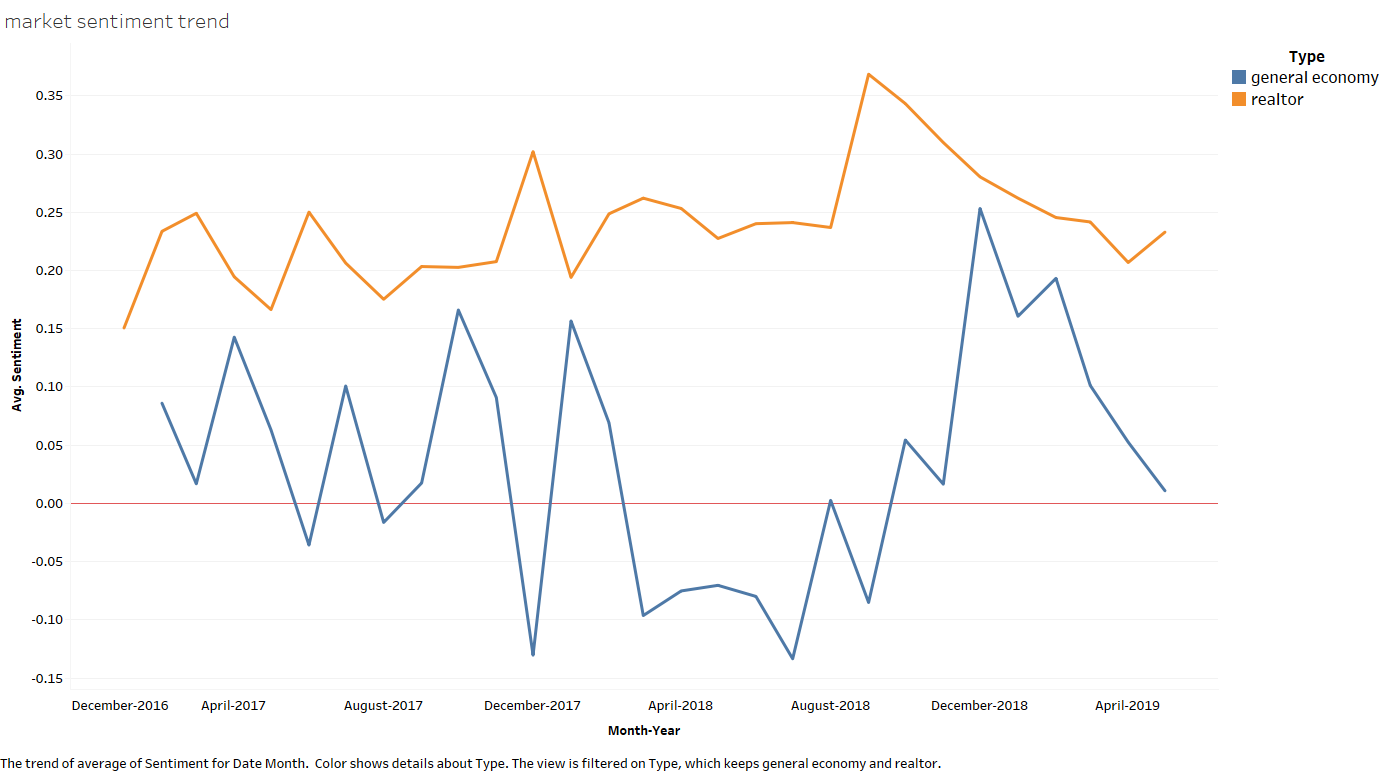

In [29]:
show_viz('market sentiment trend')

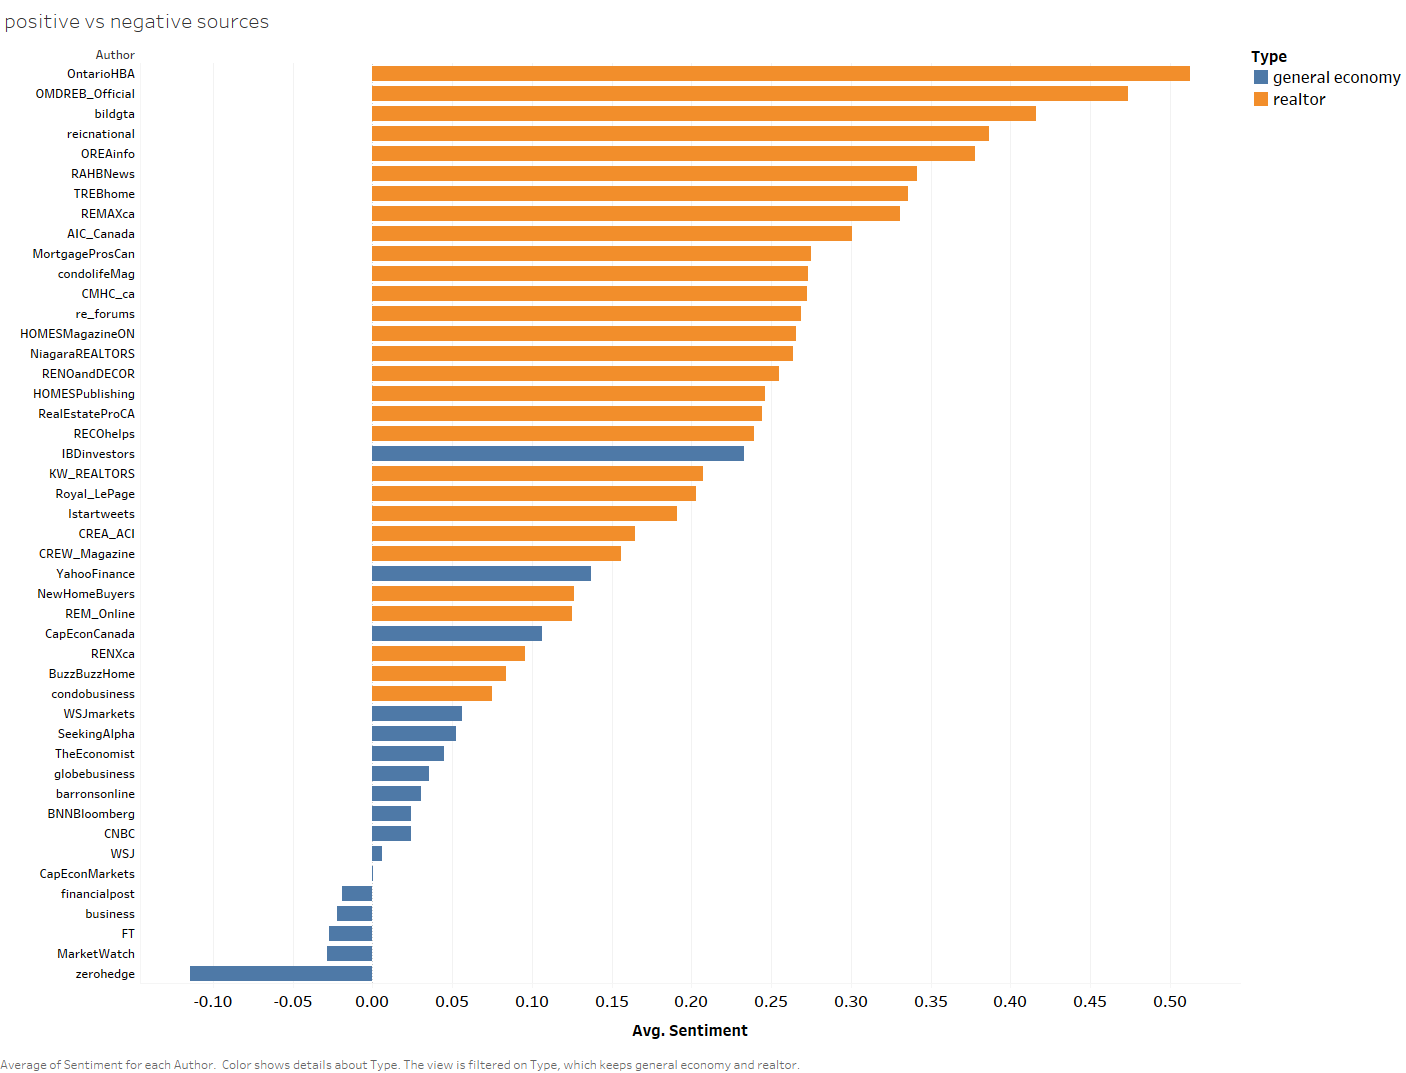

In [30]:
show_viz('positive vs negative sources')

## Price

In [31]:
df_listgroup = df_listing.groupby(by=['city','proptype']).median().reset_index()

In [32]:
df_listgroup.columns = ['city','proptype','median_ask']

In [33]:
df_ppivot = df_listgroup.pivot(index='proptype',columns='city',values='median_ask')
df_ppivot

city,Aurora,Burlington,Hamilton,Markham,Milton,Mississauga,Newmarket,Oakville,Oshawa,Pickering,Richmond Hill,Toronto,Vaughan
proptype,,,,,,,,,,,,,
Apartment,"687,000","410,950","375,000","549,900",nan,"464,950",nan,"594,900",nan,nan,"515,400","624,500","559,500"
Bungalow,"2,190,000","897,000","494,350","1,188,999","1,199,750","1,012,400","799,000","1,099,000","554,900","2,020,000","1,253,800","850,000","1,514,900"
Detached,"1,158,000","979,500","562,000","1,339,400","877,950","1,267,500","876,950","1,414,450","619,900","894,450","1,459,444","1,293,000","1,399,450"
Loft,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"796,000",nan
Semi-Detached,nan,nan,"449,450","993,950",nan,"772,450",nan,nan,"624,450",nan,nan,"899,900","864,450"
Townhouse,"790,500","599,994","517,450","799,000","599,950","666,950","722,445","789,000","459,450","519,939","876,400","704,500","859,000"


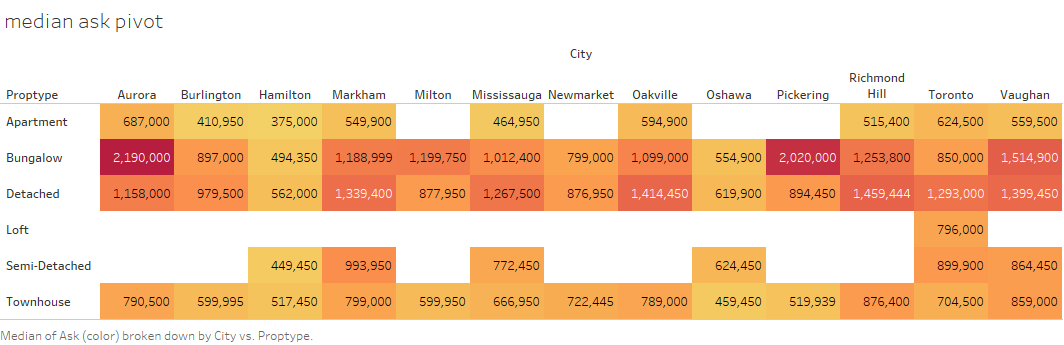

In [34]:
show_viz('median ask pivot')

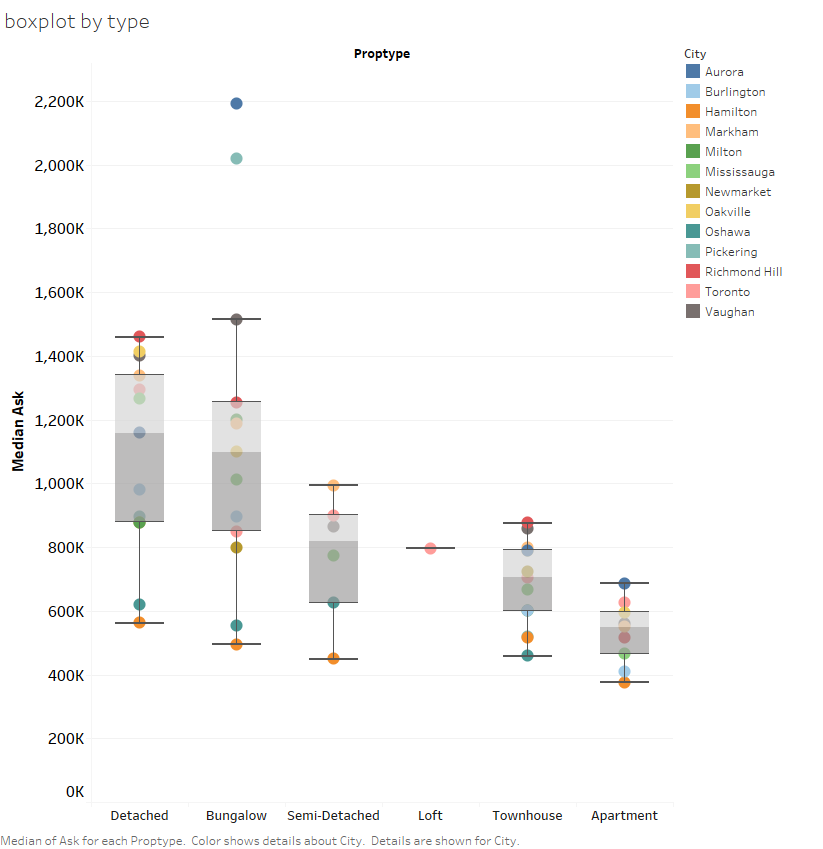

In [35]:
show_viz('boxplot by type')